<a href="https://colab.research.google.com/github/NanduRaj/ML/blob/master/SpamDetection_NaiveBayes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Spambase - Spam Detection

## Setting Up

In [0]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB, GaussianNB, BernoulliNB
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score
import csv
from numpy.random import RandomState

### Constants

In [0]:
RANDOM_SEED = 1234
EPS = 1e-8
FEATURES = ['word_freq_make', 'word_freq_address', 'word_freq_all', 'word_freq_3d', 'word_freq_our', 'word_freq_over', 'word_freq_remove', 'word_freq_internet', 'word_freq_order', 'word_freq_mail', 'word_freq_receive', 'word_freq_will', 'word_freq_people', 'word_freq_report', 'word_freq_addresses', 'word_freq_free', 'word_freq_business', 'word_freq_email', 'word_freq_you', 'word_freq_credit', 'word_freq_your', 'word_freq_font', 'word_freq_000', 'word_freq_money', 'word_freq_hp', 'word_freq_hpl', 'word_freq_george', 'word_freq_650', 'word_freq_lab', 'word_freq_labs', 'word_freq_telnet', 'word_freq_857', 'word_freq_data', 'word_freq_415', 'word_freq_85', 'word_freq_technology', 'word_freq_1999', 'word_freq_parts', 'word_freq_pm', 'word_freq_direct', 'word_freq_cs', 'word_freq_meeting', 'word_freq_original', 'word_freq_project', 'word_freq_re', 'word_freq_edu', 'word_freq_table', 'word_freq_conference', 'char_freq_;', 'char_freq_(', 'char_freq_[', 'char_freq_!', 'char_freq_$', 'char_freq_#', 'capital_run_length_average', 'capital_run_length_longest', 'capital_run_length_total', 'label']

In [0]:
np.random.seed(RANDOM_SEED)

### Utility functions

In [0]:
# compute idf
# we get the tf feature from the dataset
def compute_idf(data: np.ndarray):
    """Return the computed idf values, we are using smooth idf here """
    n = data.shape[0]
    df = (data > 0.0).astype(np.int).sum(axis=0)
    idf = np.log((n + 1.) / (df + 1.)) + 1.
    return idf

In [0]:
def transform_tfidf(data: np.ndarray, idf: np.ndarray):
    tf_idf_values_raw = data * idf
    # applying l2 norm
    norm = np.linalg.norm(tf_idf_values_raw, axis=1)
    norm += EPS # to avoid divide by zero
    tf_idf_values = tf_idf_values_raw / norm[:, None]
    return tf_idf_values

In [0]:
def print_stats(model, x, y):
    y_pred = model.predict(x)
    return classification_report(y, y_pred)

## Loading and Preprocessing

In [0]:
data = np.genfromtxt('spambase.data',delimiter=',')

In [0]:
trainX, testX, trainY, testY = train_test_split(data[:, 0:57], data[:, -1], test_size=0.2, random_state=RANDOM_SEED)

### Computing tf-idf for words

In [0]:
word_freq_features = trainX[:, 0:48]
word_idf_values = compute_idf(word_freq_features)
# save word idf values to use while prediction

In [0]:
train_word_tf_idf_values = transform_tfidf(word_freq_features, word_idf_values)

### Computing tf-idf for chars

In [0]:
char_freq_features = trainX[:, 48:54]
char_idf_values = compute_idf(char_freq_features)
# save char idf values to use while prediction

In [0]:
train_char_tf_idf_values = transform_tfidf(char_freq_features, char_idf_values)

### Preparing for train and test

In [0]:
x_train = np.hstack([train_word_tf_idf_values, train_char_tf_idf_values])
y_train = trainY

In [0]:
# preparing same op on test
test_word_tf_idf_values = transform_tfidf(testX[:, 0:48], word_idf_values)
test_char_tf_idf_values = transform_tfidf(testX[:, 48:54], char_idf_values)
x_test = np.hstack([test_word_tf_idf_values, test_char_tf_idf_values])
y_test = testY

## Model Training and Inference

### Computing 10 fold CV

In [0]:
scores = [] #for plotting purposes

multinomial_classifier = MultinomialNB()
gaussian_classifier = GaussianNB()
bernoulli_classifier = BernoulliNB(binarize=0.25)

multinomial_cv = cross_val_score(multinomial_classifier, x_train, y_train, cv=10)
multinomial_classifier_mean_score = multinomial_cv.mean()
scores.append(multinomial_classifier_mean_score)

gaussian_cv = cross_val_score(gaussian_classifier, x_train, y_train, cv=10)
gaussian_classifier_mean_score = gaussian_cv.mean()
scores.append(gaussian_classifier_mean_score)

bernoulli_cv = cross_val_score(bernoulli_classifier, x_train, y_train, cv=10)
bernoulli_classifier_mean_score = bernoulli_cv.mean()
scores.append(bernoulli_classifier_mean_score)

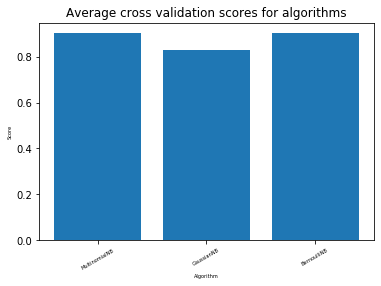

In [0]:
algorithms = ['MultinomialNB', 'GaussianNB', 'BernoulliNB']
def plot_bar_x(scores):
    index = np.arange(len(algorithms))
    plt.bar(index, scores)
    plt.xlabel('Algorithm', fontsize=5)
    plt.ylabel('Score', fontsize=5)
    plt.xticks(index, algorithms, fontsize=5, rotation=30)
    plt.title('Average cross validation scores for algorithms')
    plt.show()
    
plot_bar_x(scores)

### Mutlinomial Naive Bayes

In [0]:
multinomial_classifier = MultinomialNB()
multinomial_classifier.fit(x_train, y_train)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [0]:
print('## Train Stats\n', print_stats(multinomial_classifier, x_train, y_train))
print('--------------------------------------------------------------')
print('## Test Stats\n', print_stats(multinomial_classifier, x_test, y_test))

## Train Stats
               precision    recall  f1-score   support

         0.0       0.95      0.89      0.92      2225
         1.0       0.85      0.93      0.89      1455

    accuracy                           0.90      3680
   macro avg       0.90      0.91      0.90      3680
weighted avg       0.91      0.90      0.91      3680

--------------------------------------------------------------
## Test Stats
               precision    recall  f1-score   support

         0.0       0.96      0.91      0.94       563
         1.0       0.88      0.94      0.91       358

    accuracy                           0.93       921
   macro avg       0.92      0.93      0.92       921
weighted avg       0.93      0.93      0.93       921



### Gaussian Naive Bayes

In [0]:
gaussian_classifier = GaussianNB()
gaussian_classifier.fit(x_train, y_train)

GaussianNB(priors=None, var_smoothing=1e-09)

In [0]:
print('## Train Stats\n', print_stats(gaussian_classifier, x_train, y_train))
print('--------------------------------------------------------------')
print('## Test Stats\n', print_stats(gaussian_classifier, x_test, y_test))

## Train Stats
               precision    recall  f1-score   support

         0.0       0.95      0.77      0.85      2225
         1.0       0.73      0.94      0.82      1455

    accuracy                           0.84      3680
   macro avg       0.84      0.85      0.84      3680
weighted avg       0.86      0.84      0.84      3680

--------------------------------------------------------------
## Test Stats
               precision    recall  f1-score   support

         0.0       0.96      0.77      0.86       563
         1.0       0.73      0.95      0.82       358

    accuracy                           0.84       921
   macro avg       0.84      0.86      0.84       921
weighted avg       0.87      0.84      0.84       921



### Bernoulli Naive Bayes

In [0]:
bernoulli_classifier = BernoulliNB(binarize=0.25)
bernoulli_classifier.fit(x_train, y_train)

BernoulliNB(alpha=1.0, binarize=0.25, class_prior=None, fit_prior=True)

In [0]:
print('## Train Stats\n', print_stats(bernoulli_classifier, x_train, y_train))
print('--------------------------------------------------------------')
print('## Test Stats\n', print_stats(bernoulli_classifier, x_test, y_test))

## Train Stats
               precision    recall  f1-score   support

         0.0       0.94      0.90      0.92      2225
         1.0       0.85      0.91      0.88      1455

    accuracy                           0.90      3680
   macro avg       0.90      0.91      0.90      3680
weighted avg       0.91      0.90      0.90      3680

--------------------------------------------------------------
## Test Stats
               precision    recall  f1-score   support

         0.0       0.95      0.92      0.94       563
         1.0       0.88      0.93      0.90       358

    accuracy                           0.92       921
   macro avg       0.92      0.92      0.92       921
weighted avg       0.93      0.92      0.92       921



by 
 [*Nandu Raj, Dexlock*](https://www.linkedin.com/in/nandu-raj-548733147/)

